# POWER SPECTRUM ANALYSIS

<div class="alert alert-block alert-success" style="font-size:16px">In this exercise, you will compute the power spectrum of a time series. You will compute the amplitudes of the waves explicitly and then plot the power spectrum, with the proper significance.</div>

<div style="font-size:16px"><b>Make sure to follow the directions written in the document. <font color=green>Green</font> boxes contain important information and have <u>completed</u> code after them. <font color=gold>Yellow</font> boxes contain options that you need to select or make to continue on with the problem. <font color=blue>Blue</font> boxes contain instructions, and the cells after them are for YOU to complete in-class.</b></div>

In [1]:
#-------------------------------------------------------------------
# Import libraries.
#-------------------------------------------------------------------
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import MultipleLocator

warnings.simplefilter('ignore')

# LOAD THE TIME SERIES

<div class="alert alert-block alert-success" style="font-size:16px">Load the time series and put the result into variable $y$.</div>

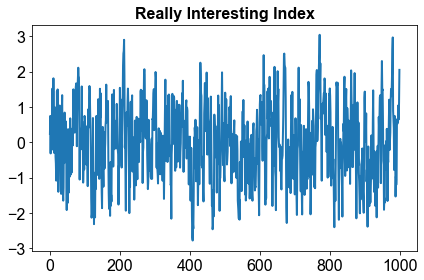

In [2]:
#-------------------------------------------------------------------
# Load in time series.
#-------------------------------------------------------------------
filename = 'ReallyInterestingIndex.txt'
y = np.loadtxt(filename)

#-------------------------------------------------------------------
# Make a quick plot.
#-------------------------------------------------------------------
plt.figure()
plt.plot(y)
plt.title('Really Interesting Index',name='Arial',size=16,weight='bold');

# DETREND Y

<div class="alert alert-block alert-info" style="font-size:16px">Detrend the time series.</div>

In [3]:
def detrend(y):
    '''
    linear regression to detrend
    
    Args:
    -------------------
    :y - numpy.ndarray; target to detrend
    
    Returns:
    -------------------
    :detrend - numpy.ndarray; 
    '''
    
    t= np.arange(len(y))
    E= np.ones((t.size,2))*np.nan
    E[:,0] = t
    E[:,1] = 1
    xhat = np.linalg.inv(np.transpose(E).dot(E)).dot(E.T).dot(y)
    trend = E.dot(xhat)
    detrend= y- trend
    
    return detrend, xhat, trend

In [4]:
y_detrend,_,_ = detrend(y)

# SET CONSTANTS FOR POWER SPECTRAL ANALYSIS.

In [5]:
num = len(y_detrend) #The length of the time series over which to conduct power spectrum analysis
N = int(np.floor(num/2.)*2) # Get an even number of points for the power spectrum analysis.

y_detrend = y_detrend[:N] # Retain an even number of points.

nyquist = int(N/2)

dt = 1. # Timestep
T = dt*N #Total time length

i = np.arange(1,N+1) #Discrete counter for the points in y.



<div class="alert alert-block alert-success" style="font-size:16px">Declare the $A$ and $B$ arrays - the two coefficients as a function of wavenumber. Here, these arrays are declared with a length of ``nyquist +1". Leave the k = 0 entry (i.e., wave-0) as a NaN value when doing your summations later - we'll discard it later.</div>

In [6]:
A = np.ones((nyquist+1,))*np.nan
B = np.ones((nyquist+1,))*np.nan

# COMPUTE THE COEFFICIENTS.

<div class="alert alert-block alert-info" style="font-size:16px">Use the equations from class to compute the coefficients. Again, skip the k = 0 wave.</div>

In [7]:
for k in range(1,nyquist):
    A[k] = sum([2/N*y_detrend[i]*np.cos(2*np.pi*k*i*dt/T) for i in range(N)])
    B[k] = sum([2/N*y_detrend[i]*np.sin(2*np.pi*k*i*dt/T) for i in range(N)])

#-------------------------------------------------------------------
# Calculate A_k and B_k at k = nyquist.
#-------------------------------------------------------------------
k = nyquist
A[k] = sum([1/N*y_detrend[i]*np.cos(np.pi*N*i*dt/T) for i in range(N)])
B[k] = 0

#-------------------------------------------------------------------
# Calculate C_k**2 - i.e., the total magnitude.
#-------------------------------------------------------------------
C2 = A**2 + B**2
C2 = C2[1:] # Keep only the k = 1, 2, 3,... values. Skip the k=0 wave.

# APPLY RUNNING MEAN.

<div class="alert alert-block alert-warning" style="font-size:16px">You can do a running mean to "smooth" the power spectrum, as we discussed in class. Set RUNMEAN to an ODD number if you want (3 or 5 will work well here). If you don't want to do this, just keep RUNMEAN as None. <b>For the in-class exercise, set RUNMEAN = 3.</div>

In [8]:
dof = 2. # DOF for single spectrum calculation.

RUNMEAN = 3
if RUNMEAN is not None:
    C2 = np.convolve(C2, np.ones((RUNMEAN,))/RUNMEAN)[(RUNMEAN-1):] #Fast way of doing a running mean.
    dof*=RUNMEAN # Applying a running mean increases the degrees of freedom for significance
                 # testing.


# SIGNIFICANCE TESTING AGAINST A RED NOISE SPECTRUM

<div class="alert alert-block alert-info" style="font-size:16px">Calculate the <b><u>experimental</u></b> red noise spectrum (rnPower) using the equation from class notes.</div>

In [9]:
k = np.arange(1,nyquist+1) # Wavenumbers
omega = 2*np.pi*k/N # Angular frequency

rho = np.corrcoef(y_detrend[1:], y_detrend[:-1])[0,1] # Lag-1 correlation of the detrended time series.
sigma_e2 = (1-rho**2)*np.var(y_detrend)

rnPower = 4*sigma_e2**2/N/(1+rho**2-2*rho*np.cos(omega))


<div class="alert alert-block alert-success" style="font-size:16px">For plotting with significance, we should scale our power spectra (i.e., the one we computed and the red noise power spectrum). We will scale our plots such that the total area under each curve is 1.</div>

In [10]:
delta = omega[1]-omega[0]
scaledPower = C2/np.nansum(delta*C2)
scaledRN = rnPower/np.nansum(delta*rnPower)


<div class="alert alert-block alert-info" style="font-size:16px">Use the $\chi^2$-test for significance testing. Use a value of $\alpha^*$ = 0.05 to calculate the nominal $\alpha$ value for the $\chi^2$ test, using the Bonferroni method from class.</div>

In [11]:
alphaStar = 0.05
alpha = alphaStar/500

sigChi2 = stats.chi2.isf(alpha,dof) # Chi-squared value for the nominal alpha value for your 95% test.


<div class="alert alert-block alert-info" style="font-size:16px">Calculate the significance curve for plotting, using the variable scaledRN, the $\chi^2$ value from above, and the formula from class.</div>

In [12]:
sigCurve = scaledRN / dof *sigChi2 

# PLOT THE RESULTS

<div class="alert alert-block alert-info" style="font-size:16px">Make the power spectrum plot. Plot the scaled power (scaledPower), the scaled red noise power spectrum (scaledRN), and the significance curve (sigCurve). Use angular frequency (omega) for the $x$-axis. For this exercise, keep the $y$-axis on a linear scale.</div>

<Figure size 432x288 with 0 Axes>

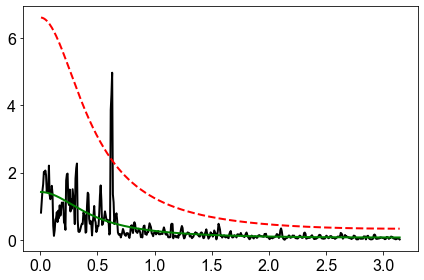

In [13]:
plt.figure()
plt.plot(omega, scaledPower, color='k')
plt.plot(omega, scaledRN, color='green')
plt.plot(omega, sigCurve, 'r--')